# Digital Twins for Triple Negative Breast Cancer
## Example notebook with in silico data
**This notebook goes through the all the steps required for calibrating and using the digital twin**
1. **Loading the data**
1. **Initializing the digital twin**
1. **Calibrating parameters with approximate Bayesian computation**
1. **Optiziming quantities of interest based on simulations**

**The model is based on the reaction diffusion equation, with parameters representing diffusion, proliferation, drug efficacy, and drug decay:** $$\dfrac{\partial N(\mathbf{x},t)}{\partial t} = d \Delta N(\mathbf{x},t) + k(\mathbf{x})N(\mathbf{x},t)(1-N(\mathbf{x},t))-N(\mathbf{x},t)\sum_{j}^{}\gamma_j(\mathbf{x},t) \tag{1}$$
$$\gamma_j(\mathbf{x},t) = \alpha C_k(\mathbf{x})\sum_{k=1}^{T_j}D_{j,k}H(D_{j,k}-0.1)\mathrm{e}^{-\beta_j(t-\tau_{j,k})H(t-\tau_{j,k})} \tag{2}$$





In [2]:
import numpy as np
import os
import pickle
import time
import sys
home = os.path.dirname(os.getcwd())
sys.path.append(home)

# Calibration can throw LinAlgWarnings depending on value of least-squares normalization
# This does not effect the model output
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings(action = 'ignore', category=LinAlgWarning)
# Simulation throws contiguous array errors
from numba.core.errors import NumbaPerformanceWarning
warnings.simplefilter(action = 'ignore', category = NumbaPerformanceWarning)

import DigitalTwin as dtwin

**Three example "patients" are provided, starting from a randomized intitial condition with randomized proliferation map and alpha value.**

**Diffusivity and drug decay are set to the prior mean.**

In [4]:
home = os.path.dirname(os.getcwd())
datapath = home + '\Examples\ExampleData_1.mat'

**Each twin requires arguments on how the input data should be processed:**
- **Should data be withheld for predicting?**
     - slice
- **Should data be downsampled and with what factors?**
     - downsample, inplane, inslice
- **3D data cropped to 2D?**
     - crop2D
     
<div class="alert alert-block alert-warning">
The model also requires operators for the reduced order model to run. These must be included but can be specified as either global (g) or local (l).
</div>

In [6]:
load_args = {'split':2,'downsample':False}

#Bounds for parameters controlling operators
bounds = {'d':np.array([1e-6, 1e-3]),'k':np.array([1e-6, 0.1]),'alpha':np.array([1e-6, 0.8])}

#What operator types are included in the ROM library
required_ops = ('A','B','H','T')
params_ops = ('d','k','k','alpha')
type_ops = ('g','l','l','g') # g = global, l = local
zipped = zip(required_ops, params_ops, type_ops)
ROM_args = {'bounds': bounds, 'zipped': zipped}

<div class="alert alert-block alert-info">
The <b>digital twin</b> can now be initialized.
</div>

In [8]:
twin = dtwin.DigitalTwin(datapath, load_args = load_args, ROM = True, ROM_args = ROM_args)

**With a prepped digital twin, we would typically want to assimilate all of the data currently available to determine the parameters for the specific "patient"**

**Parameters are created with a set assignement, and priors are generated based on the specific parameter and type**

<div class="alert alert-block alert-warning">
Reduced parameters require CoeffBounds that are calculated during the ROM build
</div>

In [10]:
#What parameter assignment is used for the model
# g = global, r = reduced, f = fixed
params = {'d':dtwin.Parameter('d','g'),
          'k':dtwin.ReducedParameter('k','r',twin.ROM['V']),
          'alpha':dtwin.Parameter('alpha','g'),
          'beta_a':dtwin.Parameter('beta_a','g'),
          'beta_c': dtwin.Parameter('beta_c','g')}
    
params['d'].setBounds(np.array([1e-6,1e-3]))
params['k'].setBounds(np.array([1e-6,0.1]))
params['k'].setCoeffBounds(twin.ROM['Library']['B']['coeff_bounds'])
params['alpha'].setBounds(np.array([1e-6,0.8]))
params['beta_a'].setBounds(np.array([0.35, 0.85]))
params['beta_c'].setBounds(np.array([1.0, 5.5]))

#Build priors for Bayesian inference
twin.setParams(params)
twin.getPriors(params)

<div class="alert alert-block alert-info">
The calibration can now run using pyABC's approximate Bayesian sampler
</div>
<b>The accepted calibration types for ROM are LM_ROM, MCMC_ROM (not validated), or ABC_ROM</b>

In [12]:
#Can be slow, does not print a detailed progress status
cal_args = {'dt': 0.5, 'options': {'n_pops': 5,'pop_size':500,'epsilon':'calibrated','distance':'MSE','burnin':0.1}}
start = time.time()
twin.calibrateTwin('ABC_ROM', cal_args)
print('ABC calibration time = ' + str(time.time() - start))

ABC.History INFO: Start <ABCSMC id=138, start_time=2024-07-30 15:19:32>
ABC INFO: Calibration sample t = -1.


Epsilon = 0.14555835290602934


ABC INFO: t: 0, eps: 3.84603966e+00.
ABC INFO: Accepted: 500 / 1077 = 4.6425e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 1.50677371e+00.
ABC INFO: Accepted: 500 / 1112 = 4.4964e-01, ESS: 4.0572e+01.
ABC INFO: t: 2, eps: 6.79190817e-01.
ABC INFO: Accepted: 500 / 1210 = 4.1322e-01, ESS: 9.9056e+00.
ABC INFO: t: 3, eps: 5.50107553e-01.
ABC INFO: Accepted: 500 / 856 = 5.8411e-01, ESS: 2.5589e+01.
ABC INFO: t: 4, eps: 3.63779847e-01.
ABC INFO: Accepted: 500 / 1284 = 3.8941e-01, ESS: 1.8217e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=138, duration=0:16:15.967035, end_time=2024-07-30 15:35:48>


ABC calibration time = 979.0941741466522


**After calibration, a prediction is made and the results are visualized**

Prediction time = 0.7320008277893066


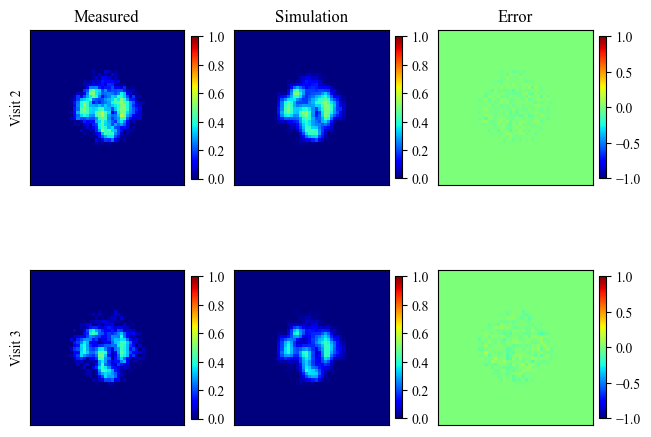

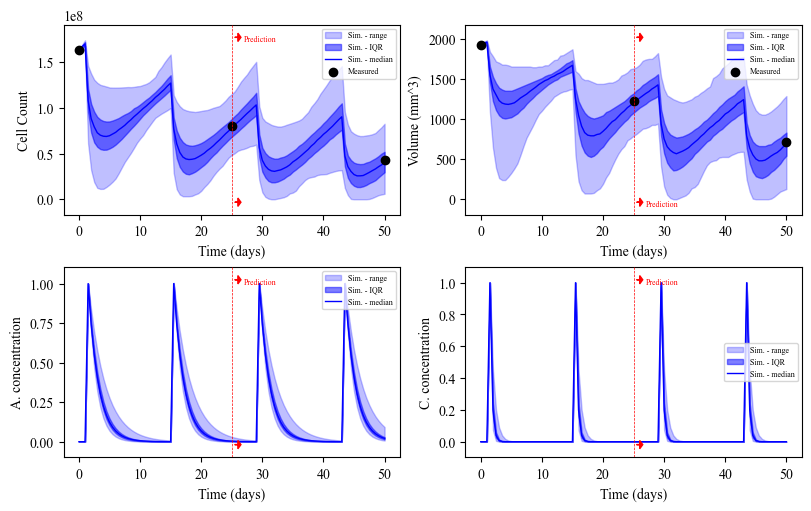

In [14]:
start = time.time()
twin.simulations = twin.predict(dt = 0.5, threshold = 0.25, plot = True, visualize = True, parallel = False)
print('Prediction time = ' + str(time.time() - start))

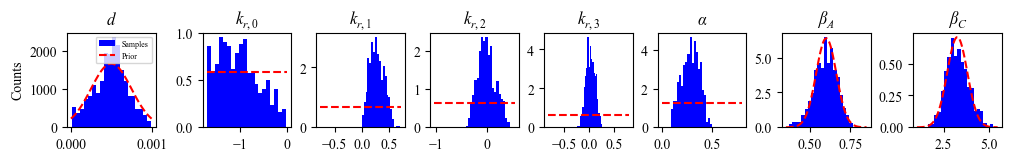

In [15]:
twin.paramVisualization()

**With a calibrated digital twin, we can either:**
- **Optimize controls based on a desired quantity of interest**
- **Assimilate new data as it becomes available**

**The first quantity of interest is the total tumor cellularity. We want to find controls that minimize this using the following optimization problem:**
$$
\begin{align*}
a) \quad \mathbf{R}_{tumor}^{*} &= \substack{\text{argmin}\\\mathbf{R}\in\mathcal{R}} \left( \frac{\text{mean} \left( \int_x N\left( \mathbf{R},t_f,\theta_{ABC} \right) \right)}{\text{mean} \left( \int_x N\left( \mathbf{R_{soc}},t_f,\theta_{ABC} \right) \right)} + \frac{\max\left(\text{mean} \left( \int_x N\left( \mathbf{R},t,\theta_{ABC} \right) \right)\right)}{\max\left(\text{mean} \left( \int_x N\left( \mathbf{R_{soc}},t,\theta_{ABC} \right) \right)\right)} \right) \\
w.r.t: \\
b) \quad &||\mathbf{D}_j||_1 \leq ||\mathbf{D}_{soc}||_1 \quad \forall j \\
c) \quad &\mathcal{C}\left( \mathbf{D}_j, \tau_j, \beta_j \right) \leq \mathcal{C}\left(\mathbf{D}_{soc}, \tau_{soc}, \beta_j\right) \quad \forall j \\
d) \quad &\mathcal{T}\left( \mathbf{D}_j, \tau_j, \beta_j \right) \leq \mathcal{T}\left(\mathbf{D}_{soc}, \tau_{soc}, \beta_j\right) \quad \forall j \tag{3}
\end{align*}
$$

**a) represents the minimization of total cells at a final time points weighted against the maximum cell number**

**b), c), d) represent constraints regarding the total dose, maximum concentration, and estimated toxicity**

<div class="alert alert-block alert-info">
The optimization can be adjusted with various combinations of objective and constraints
</div>

**Extra problem arguments:**
- **true_schedule: should the final time point be based on the drug schedule (false) or imaging data (true)**
- **metric: should mean, median, percentile, etc. be used to evaluate quantity of interest from distribution**
- **estimated: should the simulator save time during the optimization by estimating total cellularity, rather than direct calculation**
    - this removes the ability to look at volumes or change the threshold during optimization
- **partial: should the optimizer save time by only estimating the timecourse for the predicted section**
- **cycles: should the optimized regimen be split into two indentical cycles (true), or one long one (false)**
- **interval: days between allowed deliveries of drug**

Cell minimization time = 93.2029972076416


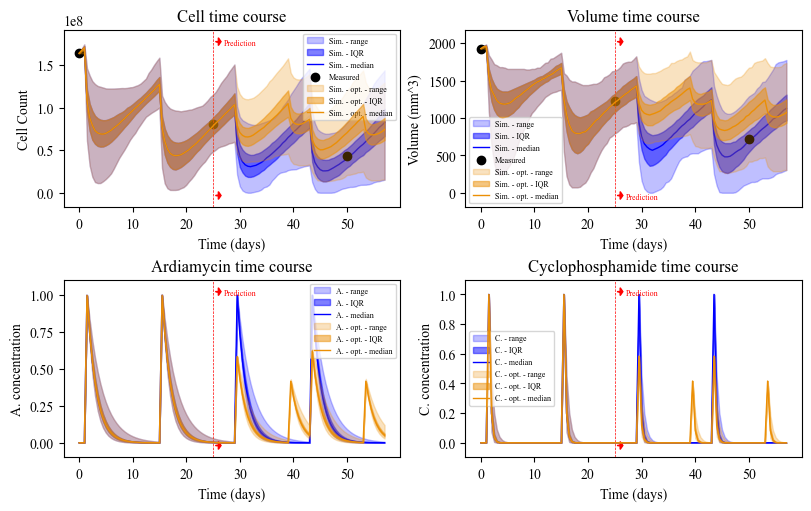

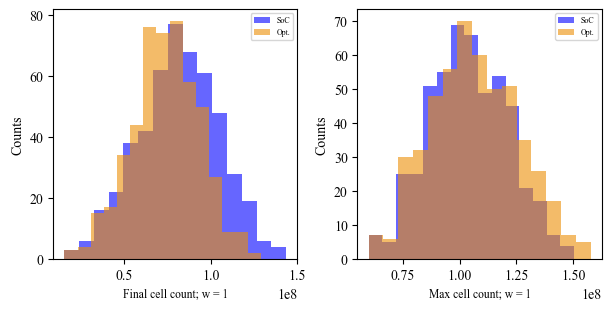

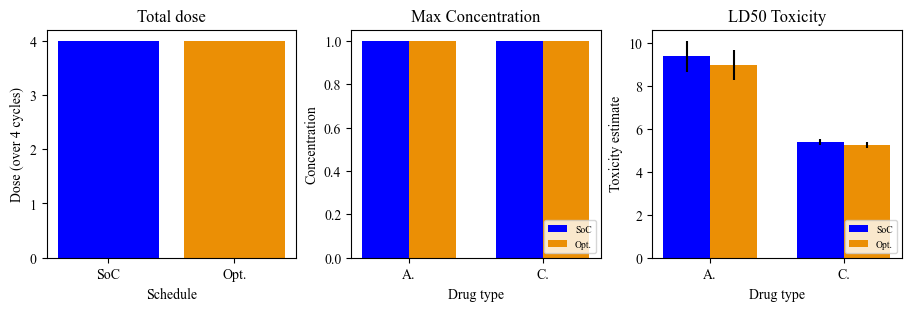

In [17]:
import Optimize as opt

thresh = 0.25
problem_args = {'objectives':['final_cells','max_cells'],
                    'constraints':['total_dose','max_concentration','ld50_toxicity'],
                    'threshold':thresh, 'max_dose':2.0, 'weights':np.array([1,1]),
                    'metric':'median','estimated':True,'true_schedule':False,
                    'partial':True,'norm':True,'cycles':True,'interval':1}

problem = opt.problemSetup_cellMin(twin, **problem_args)
start = time.time()
output = twin.optimize_cellMin(problem, method = 1, initial_guess = 2, test_guess = True)
print('Cell minimization time = ' + str(time.time() - start))
soc_simulation = twin.predict(threshold = thresh, plot = False, change_t = problem['t_pred_end'])
optimal_simulation = twin.predict(treatment = output[1], threshold = thresh, plot = False, change_t = problem['t_pred_end'])

dtwin.plotCI_comparison(soc_simulation, optimal_simulation)
objs = opt.plotObj_comparison(problem, soc_simulation, optimal_simulation)
cons = opt.plotCon_comparison(problem, soc_simulation, optimal_simulation)

**The second quantity of interest is the total dosage. We want to find controls that minimize this using the following optimization problem, starting from the result of the cell minimization:**
$$
\begin{align*}
a) \quad \mathbf{R}_{dose}^{*} &= \substack{\text{argmin}\\\mathbf{R}\in\mathcal{R}} \left( \frac{\sum_j||\mathbf{D}_{j}||_1}{\sum_j||\mathbf{D}_{soc}||_1} + \frac{\max\left(\text{mean} \left( \int_x N\left( \mathbf{R},t,\theta_{ABC} \right) \right) \right)}{\max\left(\text{mean} \left( \int_x N\left( \mathbf{R_{soc}},t,\theta_{ABC} \right) \right) \right)} \right) \\
w.r.t: \\
b) \quad &\text{mean} \left( \int_x N\left( \mathbf{R_{}},t_f,\theta_{ABC} \right) \right) \leq \text{mean} \left( \int_x N\left( \mathbf{R_{soc}},t_f,\theta_{ABC} \right) \right) \\
c) \quad &\mathcal{C}\left( \mathbf{D}_j, \tau_j, \beta_j \right) \leq \mathcal{C}\left(\mathbf{D}_{soc}, \tau_{soc}, \beta_j\right) \quad \forall j \\
d) \quad &\mathcal{T}\left( \mathbf{D}_j, \tau_j, \beta_j \right) \leq \mathcal{T}\left(\mathbf{D}_{soc}, \tau_{soc}, \beta_j\right) \quad \forall j \tag{4}
\end{align*}
$$

**a) represents the minimization of total dose weighted against the maximum cell number**

**b), c), d) represent constraints regarding the total cells at a final time point, maximum concentration, and estimated toxicity**



Dose minimization time = 75.43700289726257


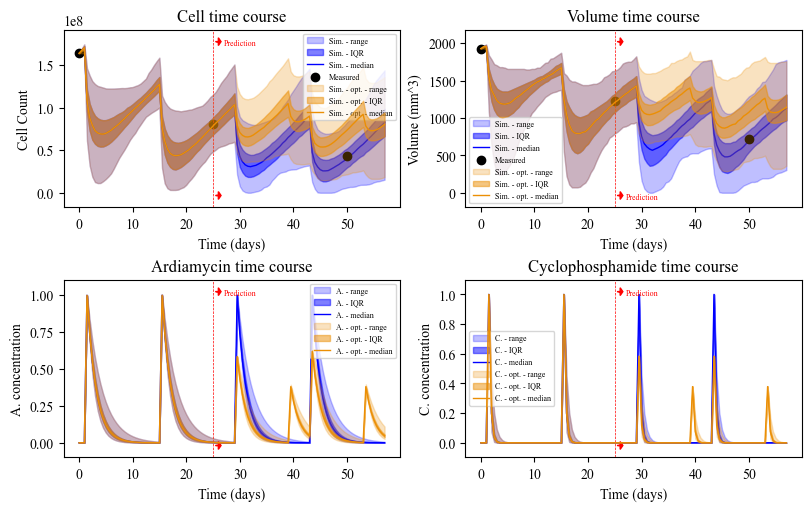

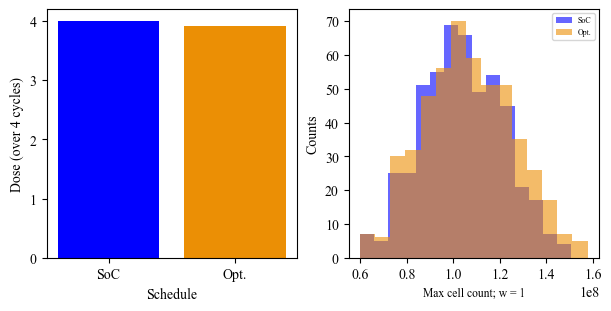

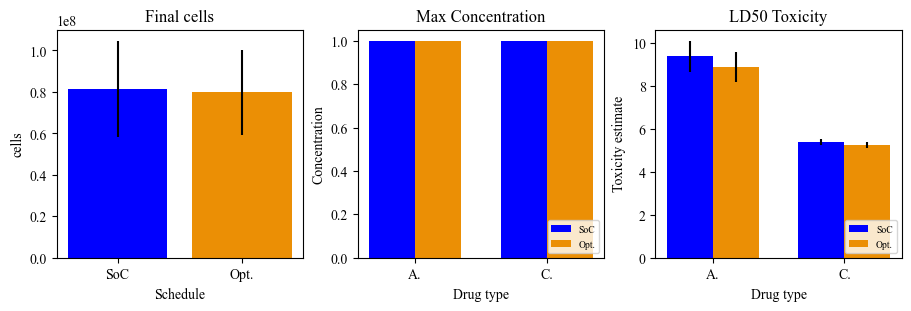

In [19]:
problem_args_dosemin = {'objectives':['total_dose','max_cells'],
                    'constraints':['final_cells','max_concentration','ld50_toxicity'],
                    'threshold':thresh, 'max_dose':2.0, 'weights':np.array([1,1]),
                    'metric':'median','estimated':True,'true_schedule':False,
                    'partial':True,'norm':True,'cycles':True,'interval':1}

problem_dosemin = opt.problemSetup_cellMin(twin, **problem_args_dosemin)
problem_dosemin['doses_guess'] = output[4].x
start = time.time()
output_dosemin = twin.optimize_cellMin(problem_dosemin, method = 1, initial_guess = 3)
print('Dose minimization time = ' + str(time.time() - start))
optimal_simulation_dosemin = twin.predict(treatment = output_dosemin[1],
                                          threshold = thresh, plot = False, change_t = problem_dosemin['t_pred_end'])

dtwin.plotCI_comparison(soc_simulation, optimal_simulation_dosemin)
objs = opt.plotObj_comparison(problem_dosemin, soc_simulation, optimal_simulation_dosemin)
cons = opt.plotCon_comparison(problem_dosemin, soc_simulation, optimal_simulation_dosemin)

**These examples are representative of the process and not designed to show specific benefits given certain parameter combinations. The small number of samples benefits the overall run time for quick visualization but prevents consistent results across runs.**

**After optimization, we can the assimilate the extra data point to use in the digital twin calibration. If more data became available we can predict and optimize for that as well**